# Objectives

1. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.
2. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.
3. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
4. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.5.0


# Playing with the Data

In [2]:
# Download the Food101 10 Classes dataset (10% training data)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip it
import zipfile
ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
ref.extractall()
ref.close()

--2021-06-25 10:09:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.164.176, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   123MB/s    in 1.3s    

2021-06-25 10:09:12 (123 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Walk through the data
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent/train.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger.
There are

In [4]:
# Setup the directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

# Create data inputs
IMG_SIZE = (224, 224);

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE);
                                                                 
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE);

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
# How many batches do we have?
print(f"Training batches: {len(train_data)} \nTest batches: {len(test_data)}")

Training batches: 24 
Test batches: 79


In [6]:
# Check the data types
train_data, test_data

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>)

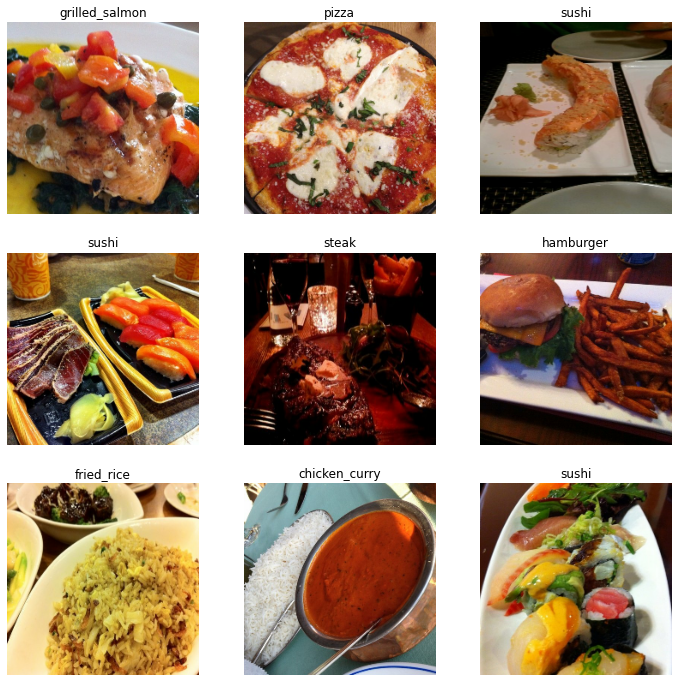

In [7]:
# Explore the training set
class_names = train_data.class_names

plt.figure(figsize=(12,12));
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis(False)

In [8]:
# Let's write a function to view a random image from a given class
import random
def view_random_image(dir="10_food_classes_10_percent/train", class_name="chicken_curry"):
  """Samples a random image belonging to the specified class and plots it"""
  # Setup the target directory
  target_dir = dir + "/" + class_name

  # Get a random file from the directory list
  filename = random.sample(os.listdir(target_dir), 1)

  # Read in the image and plot it out
  img = mpimg.imread(target_dir + "/" + filename[0])
  plt.imshow(img)
  plt.title(class_name)
  plt.axis(False);

  print(f"Image shape: {img.shape}")
  return img

Image shape: (512, 512, 3)


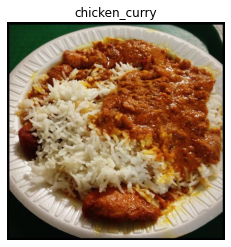

In [9]:
# Test out the function
img = view_random_image()

# Data Augmentation, Visualization and Making a Model

In [10]:
# Prepare data augmentation layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
                                         preprocessing.RandomWidth(0.2),
                                         preprocessing.RandomHeight(0.2),
                                         preprocessing.RandomZoom(0.2),
                                         preprocessing.RandomRotation(0.2),
                                         preprocessing.RandomFlip("horizontal")
], name="data_augmentation")

In [11]:
# Visualize a random image with its augmented form
def view_aug():
  """Picks a random image from the total dataset and plots it with the augmented from"""
  # Pick a random class
  target = random.choice(class_names)
  # Construct the path to an image from this class in the training set
  train_dir = "10_food_classes_10_percent/train"
  target_dir = train_dir + "/" + target
  rand_sample = random.sample(os.listdir(target_dir), 1)
  full_path = target_dir + "/" + rand_sample[0]

  # Read in the image and show both plain and augmented forms
  img = mpimg.imread(full_path)

  plt.figure()
  plt.imshow(img)
  plt.title(f"Original image from class: {target}")
  plt.axis(False);

  aug_img = data_augmentation(tf.expand_dims(img, axis=0)) # The layer expects a format of (batch_size, 224, 224, 3)
  plt.figure()
  plt.imshow(tf.squeeze(aug_img) / 255.) # .imshow does not expect the batch_size dimension like the augmentation layer
  plt.title(f"Augmented image from class {target}")
  plt.axis(False)

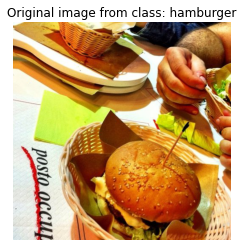

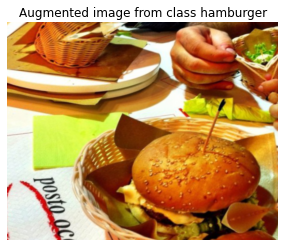

In [12]:
# View some samples
view_aug()

Now that we have done sufficient visualization, we can jump to making our first model. This model will implement Data Augmentation as a standard procedure and since it is built over `EfficientNetB0`, it will not require a new `Rescaling` layer.

Be sure to set `training=False` with the `base_model` since we do not want to tamper with the `BatchNorm` layers even when the underlying layers are all frozen. We want everything to be in "Inference" mode.

We will also implement a function to create a TensorBoard Callback so we can compare our models a bit easier. Since we will fine-tune this model later, it could help to create a `ModelCheckpoint` Callback too.

In [13]:
# Create Callback function
import datetime
def create_tensorboard_callback(experiment_name, dir_name="Finetuning_Exercises"):
  """A function that instantiates the appropriate Callback, saving the information to a path specified by the function arguments"""
  # Specify the path
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  # Instantiate and return the callback
  callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving logs to {log_dir}")
  return callback

# ModelCheckpoint for saving weights
checkpoint_path = "model_checkpoint_weights.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [14]:
# Create a Frozen Base Model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create an input layer
IMG_SHAPE = IMG_SIZE + (3,)
inputs = tf.keras.layers.Input(shape=IMG_SHAPE, name="input_layer")

# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.) <- Use this for ResNet; EfficientNet has this built in

# Augment the images randomly
x = data_augmentation(inputs)

# Pass the inputs to the base model after augmentation
x = base_model(inputs, training=False)
print(f"Shape after passing to base_model: {x.shape}")

# Pool the output of the base model to pass it into the Dense Head
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# Pass to the Output Activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the full model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing to base_model: (None, 7, 7, 1280)
Shape after Global Average Pooling: (None, 1280)


In [15]:
# Now to specify more variables and fit the first model for 10 epochs (Feature Extraction Transfer learning) 
STEPS_PER_EPOCH = len(train_data)
VALIDATION_STEPS = len(test_data)
initial_epochs = 10

history_0 = model_0.fit(train_data,
                        epochs=initial_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.4*VALIDATION_STEPS),
                        callbacks=[create_tensorboard_callback(experiment_name="feature_extraction_10_epochs"),
                                   checkpoint_callback])

Saving logs to Finetuning_Exercises/feature_extraction_10_epochs/20210625-100923
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 44s 414ms/step - loss: 1.7895 - accuracy: 0.4573 - val_loss: 1.2610 - val_accuracy: 0.7288

Epoch 00001: val_loss improved from inf to 1.26103, saving model to model_checkpoint_weights.ckpt
Epoch 2/10
24/24 [==============================] - 8s 314ms/step - loss: 1.0543 - accuracy: 0.7573 - val_loss: 0.8855 - val_accuracy: 0.8024

Epoch 00002: val_loss improved from 1.26103 to 0.88548, saving model to model_checkpoint_weights.ckpt
Epoch 3/10
24/24 [==============================] - 8s 315ms/step - loss: 0.7687 - accuracy: 0.8147 - val_loss: 0.7157 - val_accuracy: 0.8327

Epoch 00003: val_loss improved from 0.88548 to 0.71574, saving model to model_checkpoint_weights.ckpt
Epoch 4/10
24/24 [==============================] - 8s 315ms/step - loss: 0.6305 - accuracy: 0.8467 - val_loss: 0.6356 - val_accuracy: 0.8387

Epoch 00004: val_loss improved from 0.71574 to 0.63562, saving model to model_checkpoint_weights.ckpt
Epoch 5/10
24/24 [================

In [52]:
# Evaluate the model on the full testing set
results_0 = model_0.evaluate(test_data)
results_0

79/79 [==============================] - 9s 104ms/step - loss: 0.4985 - accuracy: 0.8540


[0.49848660826683044, 0.8539999723434448]

In [17]:
# Save the history to a dictionary for later comparisons
histories = dict()
histories["model_0"] = history_0;

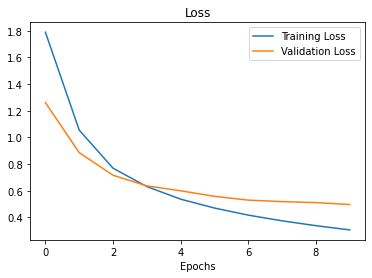

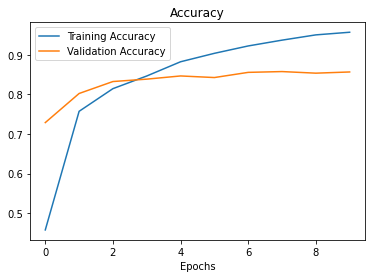

In [18]:
# Make a function to plot the Loss curves
def plot_loss_curves(history):
  # Grab the information
  acc = history.history["accuracy"]
  loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  
  epochs = range(len(history.history["loss"]))

  # Plot the Loss curves
  plt.figure()
  plt.plot(epochs, loss, label="Training Loss")
  plt.plot(epochs, val_loss, label="Validation Loss")
  plt.xlabel("Epochs")
  plt.title("Loss")
  plt.legend();

  # Plot curves for accuracy
  plt.figure()
  plt.plot(epochs, acc, label="Training Accuracy")
  plt.plot(epochs, val_acc, label="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.title("Accuracy")
  plt.legend();

# Try it out
plot_loss_curves(history_0)

The baseline model looks to perform amazingly though we haven't started Fine-tuning just yet. From the Loss Curves' gap, we can see that the model is starting to Overfit. We could have also inferred this from the huge gap in between the curves for Accuracy on the training and validation sets.

Since we have a model, let's write a function that will grab an image from either the Training or Test set, belonging to any class we want, and have our model make a prediction on it.

In [47]:
def prep_view_predict(model, train_set=True, target="chicken_curry", class_names=class_names):
  """Gets a random image from either the training or test set, belonging to a particular class, plots it and has the specified model make a prediction on it"""
  # Specify the path
  root_dir = "10_food_classes_10_percent/"

  if train_set:
    root_dir += "train/"
  else:
    root_dir += "test/"
  
  path = root_dir + target

  # Get a random file and construct the full path
  random_file = random.sample(os.listdir(path), 1)
  full_path = path + "/" + random_file[0]

  # Read in the file 
  img = tf.io.read_file(full_path)

  # Decode the image
  img = tf.image.decode_image(img)

  # Resize for our model
  img = tf.image.resize(img, size=[224, 224])

  # Model makes a prediction
  probs = model.predict(tf.expand_dims(img, axis=0)) # Expand the axis to give the same dimensions as a mini-batch
  predicted_class = class_names[np.argmax(probs)]
  prob = tf.reduce_max(probs)

  # Show the image along with the prediction information
  plt.imshow(img / 255.)

  color = "red";
  if predicted_class == target:
    color = "green"

  plt.title(f"Predicted '{predicted_class}' {np.round(prob*100, decimals=1)}% ; True: {target}", color=color)
  plt.axis(False)

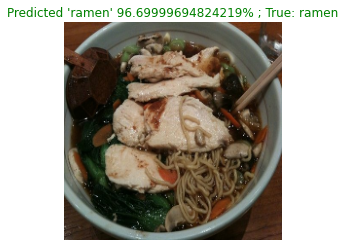

In [48]:
# Try out random predictions
targ = random.choice(class_names)
prep_view_predict(model_0, target=targ)

Beautiful.

Up till now we have trained our Feature Extraction Transfer Learning model and had it make predictions on custom images that we then visualized with a nice display. Now to work on fine-tuning.

## Fine-tuning

The last two objectives were:
1. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
2. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In Transfer Learning we will have to unfreeze the layer we desire and to train the whole model at a *lower* learning rate than before. A good rule of thumb is to lower the Learning Rate by a factor of 10.

To be clear, we will fine-tune the **existing model** rather than create a new one. This saves time on experimentation and if we want to use a model we trained halfway through the process, we'll know what changes we made and hence we can make it again from scratch if we desire.

In [50]:
# Check the layers in model_0
for i, layer in enumerate(model_0.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 False
2 global_average_pooling_layer True
3 output_layer True


Note that the pretrained `EfficientNetB0` is not `trainable` just like we expected (since we froze it ourselves). 

In [54]:
# How many variables are trainable in our base model?
len(model_0.layers[1].trainable_variables)

0

In [55]:
# Check how many layers are trainable in the base model?
count = 0
for layer in model_0.layers[1].layers:
  count += int(layer.trainable)
print(f"Number of trainable layers in EfficientNetB0: {count}")

Number of trainable layers in EfficientNetB0: 0


This is what we expected. Now we can start to unfreeze some of the layers in accordance with our objectives. We start with unfreezing the last 20 layers in the base model and training *for another* 10 epochs.

In [56]:
# Unfreeze the model
model_0.trainable = True

# Freeze everything except the last twenty layers
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile the model, with a lower learning rate since we are fine-tuning now
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [57]:
# Check how many layers are trainable in the base model now?
count = 0
for layer in model_0.layers[1].layers:
  count += int(layer.trainable)
print(f"Number of trainable layers in EfficientNetB0 after unfreezing: {count}")

Number of trainable layers in EfficientNetB0 after unfreezing: 20


In [58]:
# Show the last 40 layers of EfficientNetB0 to make sure
for layer in model_0.layers[1].layers[-40:]:
  print(layer.name, layer.trainable)

block6c_se_squeeze False
block6c_se_reshape False
block6c_se_reduce False
block6c_se_expand False
block6c_se_excite False
block6c_project_conv False
block6c_project_bn False
block6c_drop False
block6c_add False
block6d_expand_conv False
block6d_expand_bn False
block6d_expand_activation False
block6d_dwconv False
block6d_bn False
block6d_activation False
block6d_se_squeeze False
block6d_se_reshape False
block6d_se_reduce False
block6d_se_expand False
block6d_se_excite False
block6d_project_conv True
block6d_project_bn True
block6d_drop True
block6d_add True
block7a_expand_conv True
block7a_expand_bn True
block7a_expand_activation True
block7a_dwconv True
block7a_bn True
block7a_activation True
block7a_se_squeeze True
block7a_se_reshape True
block7a_se_reduce True
block7a_se_expand True
block7a_se_excite True
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


Beautiful.

Now to fine-tune for 10 epochs on top of the original 10 epochs.

In [59]:
# Fine tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model 
history_finetune_last_20_unfrozen = model_0.fit(train_data,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_0.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.4 * VALIDATION_STEPS),
                                               callbacks=[create_tensorboard_callback(experiment_name="finetune_last_20_unfrozen")]) # name experiment appropriately

Saving logs to Finetuning_Exercises/finetune_last_20_unfrozen/20210625-113743
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 15s 363ms/step - loss: 0.2491 - accuracy: 0.9440 - val_loss: 0.4442 - val_accuracy: 0.8569
Epoch 11/20
24/24 [==============================] - 6s 253ms/step - loss: 0.1439 - accuracy: 0.9707 - val_loss: 0.4620 - val_accuracy: 0.8427
Epoch 12/20
24/24 [==============================] - 6s 254ms/step - loss: 0.0914 - accuracy: 0.9827 - val_loss: 0.4433 - val_accuracy: 0.8558
Epoch 13/20
24/24 [==============================] - 8s 322ms/step - loss: 0.0540 - accuracy: 0.9920 - val_loss: 0.4377 - val_accuracy: 0.8589
Epoch 14/20
24/24 [==============================] - 6s 253ms/step - loss: 0.0305 - accuracy: 0.9987 - val_loss: 0.4524 - val_accuracy: 0.8558
Epoch 15/20
24/24 [==============================] - 8s 320ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.4488 - val_accuracy: 0.8599
Epoch 16/20
24/24 [==============================] - 8s 322ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.4957 - val_accuracy: 0.8569
Epoch 17/2

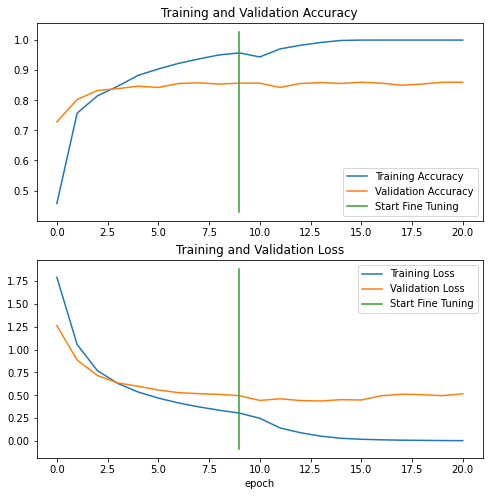

In [61]:
# In order to see exactly how training progressed after fine-tuning, we need another function
def compare_historys(original_history, new_history, initial_epochs=10):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Check how fine-tuning worked.
compare_historys(history_0, history_finetune_last_20_unfrozen)

# Don't forget to save the history object somewhere
histories["finetune_last_20_unfrozen"] = history_finetune_last_20_unfrozen;

Yikes.

The model is starting to overfit rather badly now. It achieves perfect accuracy on the training set apparently, and scores significantly lower on the test set. The gap between the loss curve is growing a lot now.

## Another Fine-tuning Experiment

Now to try the final experiment and see if there are any surprising developments. 

We shall make use of the saved weights of the `ModelCheckpoint` callback from before. 

In [62]:
# Check how the model performs now
results_finetune_last_20 = model_0.evaluate(test_data)
results_finetune_last_20

79/79 [==============================] - 9s 104ms/step - loss: 0.5349 - accuracy: 0.8512


[0.5348613262176514, 0.8511999845504761]

In [63]:
# Revert the weights 
model_0.load_weights(checkpoint_path)

In [64]:
# Check if the model has changed scores (if it has, the weights have been properly reverted)
model_0.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.4985 - accuracy: 0.8540


[0.49848672747612, 0.8539999723434448]

Okay. Good. Our model has reverted to the stage before the first fine-tuning experiment which means we can now see how unfreezing the **last 30** layers will affect performance differently.

It would be a good idea to save the evaluation metrics, along with the `History` objects for all the experiments in appropriate variables for easy comparison later.

In [65]:
# Check which layers are trainable
for i, layer in enumerate(model_0.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 True
2 global_average_pooling_layer True
3 output_layer True


In [66]:
# Which of the last 40 layers in EfficientNetB0 are trainable?
for i, layer in enumerate(model_0.layers[1].layers[-40:]):
  print(i, layer.name, layer.trainable)

0 block6c_se_squeeze False
1 block6c_se_reshape False
2 block6c_se_reduce False
3 block6c_se_expand False
4 block6c_se_excite False
5 block6c_project_conv False
6 block6c_project_bn False
7 block6c_drop False
8 block6c_add False
9 block6d_expand_conv False
10 block6d_expand_bn False
11 block6d_expand_activation False
12 block6d_dwconv False
13 block6d_bn False
14 block6d_activation False
15 block6d_se_squeeze False
16 block6d_se_reshape False
17 block6d_se_reduce False
18 block6d_se_expand False
19 block6d_se_excite False
20 block6d_project_conv True
21 block6d_project_bn True
22 block6d_drop True
23 block6d_add True
24 block7a_expand_conv True
25 block7a_expand_bn True
26 block7a_expand_activation True
27 block7a_dwconv True
28 block7a_bn True
29 block7a_activation True
30 block7a_se_squeeze True
31 block7a_se_reshape True
32 block7a_se_reduce True
33 block7a_se_expand True
34 block7a_se_excite True
35 block7a_project_conv True
36 block7a_project_bn True
37 top_conv True
38 top_bn Tru

Since we unfroze the last 20, and **just restored the weights**, this was expected.

Now we are to unfreeze the last 30 layers and carry out fine-tuning for another 10 epochs, similar to the last experiment.

In [67]:
# Unfreeze the last 30 layers in the base model
for layer in base_model.layers[-30:]:
  layer.trainable = True

# Which of the last 40 layers in EfficientNetB0 are trainable now?
for i, layer in enumerate(model_0.layers[1].layers[-40:]):
  print(i, layer.name, layer.trainable)

0 block6c_se_squeeze False
1 block6c_se_reshape False
2 block6c_se_reduce False
3 block6c_se_expand False
4 block6c_se_excite False
5 block6c_project_conv False
6 block6c_project_bn False
7 block6c_drop False
8 block6c_add False
9 block6d_expand_conv False
10 block6d_expand_bn True
11 block6d_expand_activation True
12 block6d_dwconv True
13 block6d_bn True
14 block6d_activation True
15 block6d_se_squeeze True
16 block6d_se_reshape True
17 block6d_se_reduce True
18 block6d_se_expand True
19 block6d_se_excite True
20 block6d_project_conv True
21 block6d_project_bn True
22 block6d_drop True
23 block6d_add True
24 block7a_expand_conv True
25 block7a_expand_bn True
26 block7a_expand_activation True
27 block7a_dwconv True
28 block7a_bn True
29 block7a_activation True
30 block7a_se_squeeze True
31 block7a_se_reshape True
32 block7a_se_reduce True
33 block7a_se_expand True
34 block7a_se_excite True
35 block7a_project_conv True
36 block7a_project_bn True
37 top_conv True
38 top_bn True
39 top_a

In [68]:
# Final check: how many layers are trainable in EfficientNet?
count = 0
for layer in model_0.layers[1].layers:
  count += int(layer.trainable)

print(f"Number of trainable layers in EfficientNetB0 for the second experiment: {count}")

Number of trainable layers in EfficientNetB0 for the second experiment: 30


Perfect!

Now to continue with recompiling and training!

In [70]:
# Refit the model 
history_finetune_last_30_unfrozen = model_0.fit(train_data,
                                               epochs=fine_tune_epochs, # Another 10 for fine-tuning
                                               validation_data=test_data,
                                               initial_epoch=history_0.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.4 * VALIDATION_STEPS),
                                               callbacks=[create_tensorboard_callback(experiment_name="finetune_last_30_unfrozen")]) # name experiment appropriately

Saving logs to Finetuning_Exercises/finetune_last_30_unfrozen/20210625-120632
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 9s 358ms/step - loss: 0.4916 - accuracy: 0.8427 - val_loss: 0.7539 - val_accuracy: 0.7480
Epoch 11/20
24/24 [==============================] - 8s 324ms/step - loss: 0.2073 - accuracy: 0.9213 - val_loss: 0.8778 - val_accuracy: 0.7520
Epoch 12/20
24/24 [==============================] - 6s 256ms/step - loss: 0.0598 - accuracy: 0.9800 - val_loss: 0.8400 - val_accuracy: 0.7994
Epoch 13/20
24/24 [==============================] - 8s 323ms/step - loss: 0.0659 - accuracy: 0.9813 - val_loss: 0.6809 - val_accuracy: 0.8407
Epoch 14/20
24/24 [==============================] - 6s 254ms/step - loss: 0.0539 - accuracy: 0.9827 - val_loss: 0.6469 - val_accuracy: 0.8306
Epoch 15/20
24/24 [==============================] - 6s 253ms/step - loss: 0.0294 - accuracy: 0.9933 - val_loss: 0.8131 - val_accuracy: 0.8236
Epoch 16/20
24/24 [==============================] - 8s 321ms/step - loss: 0.0126 - accuracy: 0.9973 - val_loss: 0.8212 - val_accuracy: 0.8327
Epoch 17/20

In [71]:
# Save the performance
results_finetune_last_30 = model_0.evaluate(test_data)
results_finetune_last_30

79/79 [==============================] - 9s 106ms/step - loss: 0.6697 - accuracy: 0.8436


[0.669665515422821, 0.8435999751091003]

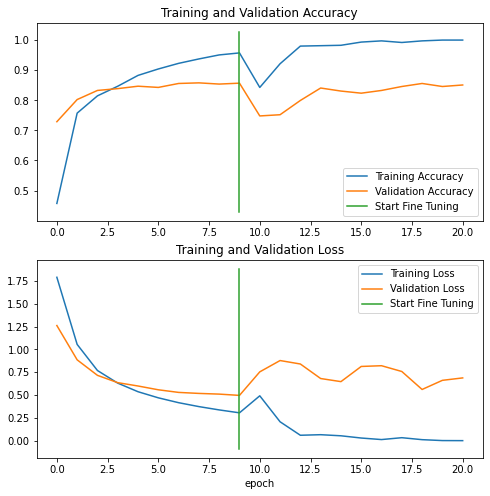

In [72]:
# Plot the losses before commenting
compare_historys(history_0, history_finetune_last_30_unfrozen)

## Some comments

Now both of our finetuned models Overfit to the training set (getting perfect accuracy in that).

The finetuned model with the last 30 layers unfrozen in the base model had a rather erratic performance on the Validation set as the epochs passed as seen by the jumpy loss curves (which did flatten out towards the end). 

The final scores on the Validation Set:
* Baseline model with only Feature Extraction fine-tuning: 0.854
* Finetuned model with the last 20 layers unfrozen: 0.851
* Finetuned model with the last 30 layers unfrozen: 0.844

Some things we could have tried differently:
* Tried an even smaller learning rate since we were training the imported models for a full 20 epochs.
* Tried a more complex architecture of `EfficientNet` like B4 onwards.
* Used the `LearningRateScheduler` to find an ideal Learning Rate.
* Implemented `EarlyStopping` to mitigate Overfitting.



# FIN